In [1]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import qutip as qt
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import importlib

%matplotlib ipympl
plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=200, formatter={'float': '{:.1e}'.format})

In [2]:
# Fundamental constants
h    = 6.62607015e-34
GHz = 1e9
e0   = 1.602176634e-19
Φ_0 = h/(2*e0)

# Single qubit

This notebook studies the qubit proposed by KIT. It's lumped element model is:
<img src='Other/Single qubit 4 nodes CC coupled to ground.jpg' width='500'>


# Circuit definitions
## Qubit

In [3]:
# Circuit parameters
Csh = 15
C   = 15
Cg  = 10
CJ  = 3
Lq  = 25
Lr  = 10
Δ   = 0.1
EJ  = 10.0
l = Lq*(Lq+4*Lr) - 4*Δ**2

In [4]:
qubit = sq_ext.KITqubit()
loop = qubit.loops[0]
qubit.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [5]:
sq_ext.print_flux_transformation(qubit)

Φ_1 = [ 0.00  0.00  1.00]
Φ_2 = [ 1.00  0.98  0.61]
Φ_3 = [-0.93  1.00  0.02]


# Equivalent circuits

### Equivalent circuit constructed as a fluxonium + resonator without coupling

In [6]:
loop_eq_fluxonium = sq.Loop(0.5)
loop_eq_ficticious = sq.Loop(0.5)

C_r_eq = sq.Capacitor(C / 2, 'fF')
L_r_eq = sq.Inductor(l / Lq, 'nH')

C_f_eq = sq.Capacitor(C / 2 + Csh + CJ, 'fF')
L_f_eq = sq.Inductor(l / (Lq + 4 * Lr), 'nH', loops=[loop_eq_ficticious])
JJ_f_eq = sq.Junction(EJ, 'GHz', loops=[loop_eq_fluxonium])

equiv_elements = {
    (0, 1): [C_r_eq, L_r_eq, C_f_eq, L_f_eq, JJ_f_eq],
}
qubit_unc = sq.Circuit(equiv_elements)
qubit_unc.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Equivalent circuit constructed as a fluxonium + resonator + coupling

In [7]:
loop_eq_fluxonium = sq.Loop(0.5)
loop_eq_ficticious = sq.Loop(0.5)

C_r_eq = sq.Capacitor(C / 2, 'fF')
L_r_eq = sq.Inductor(1 / (1 / (l / Lq) - 1 / (l / Δ)), 'nH')

C_f_eq = sq.Capacitor(C / 2 + Csh + CJ, 'fF')
L_f_eq = sq.Inductor(1 / (1 / (l / (Lq + 4 * Lr)) - 1 / (l / Δ)), 'nH', loops=[loop_eq_fluxonium, loop_eq_ficticious])
JJ_f_eq = sq.Junction(EJ, 'GHz', loops=[loop_eq_fluxonium])

L_c_eq = sq.Inductor(l / Δ, 'nH')

equiv_elements = {
    (0, 1): [C_r_eq, L_r_eq],
    (1, 2): [L_c_eq],
    (0, 2): [C_f_eq, L_f_eq, JJ_f_eq],
}
qubit_equiv = sq.Circuit(equiv_elements)
qubit_equiv.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [8]:
sq_ext.print_flux_transformation(qubit_equiv)

Φ_1 = [-1.00  0.00]
Φ_2 = [ 0.02  1.00]


### Resonator

In [9]:
resonator_elements = {
    (0, 1): [sq.Capacitor(C/2, 'fF'), sq.Inductor (l/Lq, 'nH')],
}
resonator = sq.Circuit(resonator_elements )
resonator.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Fluxonium

In [10]:
loop_fluxonium = sq.Loop(0.5)
fluxonium_elements = {
    (0, 1): [sq.Capacitor(C/2 + Csh + CJ, 'fF'), sq.Inductor(l/(Lq+4*Lr), 'nH', loops=[loop_fluxonium]), sq.Junction(EJ, 'GHz', loops=[loop_fluxonium])],
    # (0, 1): [sq.Inductor(l/(Lq+4*Lr), 'nH', loops=[loop_fluxonium]), sq.Junction(EJ, 'GHz', loops=[loop_fluxonium], cap=sq.Capacitor(C/2 + Csh + CJ, 'fF'))],
}
fluxonium = sq.Circuit(fluxonium_elements)
fluxonium.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Spectrum

## Resonator spectrum

In [11]:
L_r = l/Lq * 1e-9
C_r = C/2 * 1e-15
w_r = 1/np.sqrt(L_r*C_r) / 2 / np.pi / 1e9
E_harm = w_r * np.arange(0,8)
E_harm

array([0.0e+00, 7.2e+00, 1.4e+01, 2.2e+01, 2.9e+01, 3.6e+01, 4.3e+01, 5.0e+01])

## Spectrum vs external flux

In [12]:
qubit.set_trunc_nums([1, 5, 10])
fluxonium.set_trunc_nums([10])

# spectrum of the qubit
# phi = np.linspace(0,1,200)
#
phi = np.concatenate((np.linspace(0,0.36,50),np.linspace(0.36,0.38,50), np.linspace(0.38,1,50)))
n_eig=8
E_circuit = np.zeros((n_eig, len(phi)))
E_fluxonium = np.zeros((n_eig, len(phi)))

eig_colors = plt.get_cmap('viridis_r')(np.linspace(0, 255, n_eig).astype('int'))
for i in range(len(phi)):
    # set the external flux for the loop
    loop_fluxonium.set_flux(phi[i])
    loop.set_flux(phi[i])
    # diagonalize the qubit
    E_circuit[:, i] = qubit.diag(n_eig)[0]
    E_fluxonium[:, i] = fluxonium.diag(n_eig)[0]

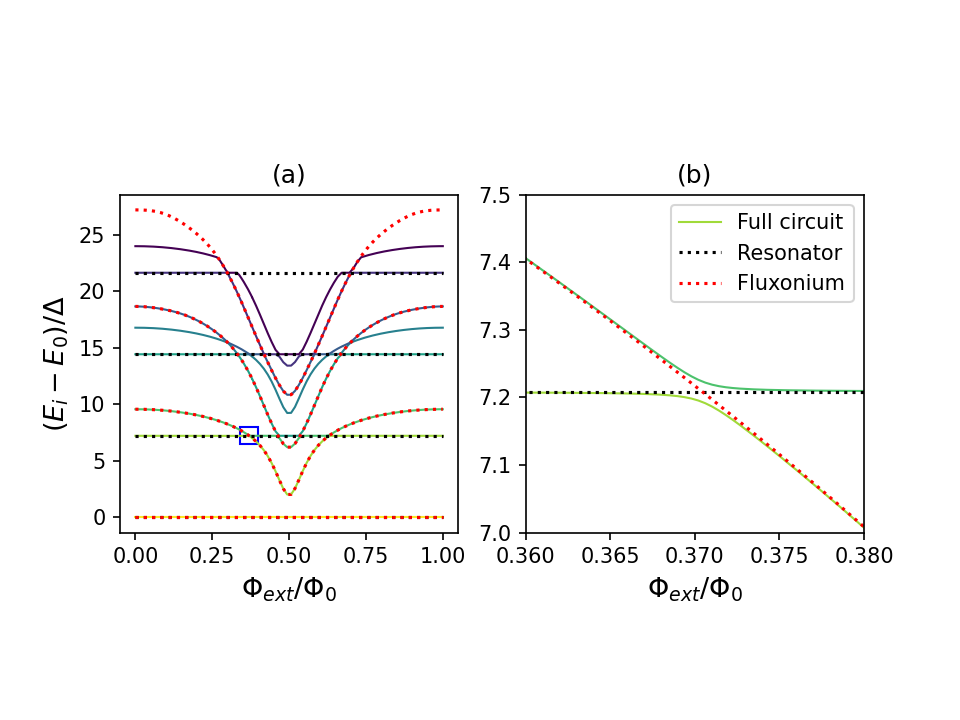

In [13]:
import matplotlib.patches as patches

# Create a rectangle with no fill

fig, axs = plt.subplots(dpi=150, ncols=2)

for ax in axs:
    for i in range(n_eig):
        if i ==1:
            ax.plot(phi, E_circuit[i,:]- E_circuit[0,:], color=eig_colors[i], linewidth=1, label='Full circuit')
        else:
            ax.plot(phi, E_circuit[i,:]- E_circuit[0,:], color=eig_colors[i], linewidth=1)
    for i in range(n_eig//2):
        if i ==0:
            ax.plot([phi[0],phi[-1]], [E_harm[i],E_harm[i]], ':k' , label='Resonator')
            ax.plot(phi, E_fluxonium[i,:]- E_fluxonium[0,:], color='r', linestyle = ':', label='Fluxonium')
        else:
            ax.plot([phi[0],phi[-1]], [E_harm[i],E_harm[i]], ':k' )
            ax.plot(phi, E_fluxonium[i,:]- E_fluxonium[0,:], color='r', linestyle = ':')

    ax.set_box_aspect(1)
    ax.set_xlabel(r"$\Phi_{ext}/\Phi_0$", fontsize=13)
    if ax == axs[0]:
        rect = patches.Rectangle((0.34, 6.5), 0.06, 1.5, linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
        ax.set_title('(a)')
        ax.set_ylabel(r"$(E_i-E_0)/\Delta$", fontsize=13)
    else:
        ax.set_title('(b)')
        ax.set_xlim(0.36,0.38)
        ax.set_ylim(7,7.5)
        ax.legend()
fig.show()
# figs.export('Spectrum.pdf')

# Eigenstates

In [14]:
fig_eigs, axs_eigs = plt.subplots(nrows=2, ncols=2)

## Potential energy and eigenstates resoantor

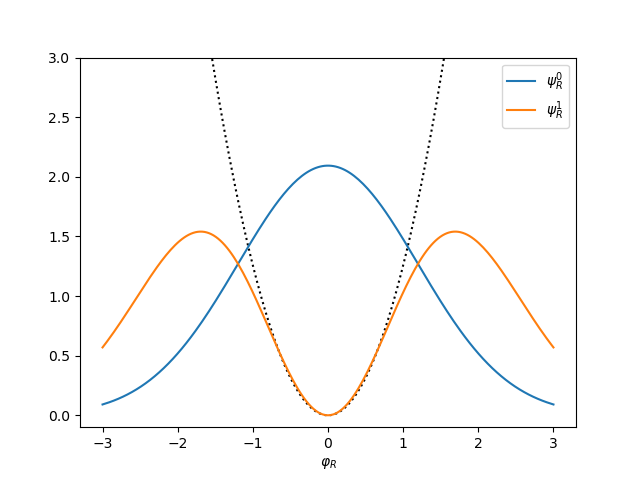

In [15]:
E_L_r = (Φ_0/(2*np.pi))**2/L_r / h

φ_r = np.linspace(-3,3,200)
n_eig = 2

V_r = 0.5 * E_L_r * (φ_r)**2

resonator.set_trunc_nums([20])
_, _ = resonator.diag(n_eig)

states_r = [resonator.eig_phase_coord(k=i, grid=[φ_r/2/np.pi]) for i in range(n_eig)]
labels_r = [r'$\psi_R^0$', r'$\psi_R^1$']

fig, ax_r = plt.subplots()
for ax in [ax_r, axs_eigs[0,0]]:
    ax.plot(φ_r, (V_r-V_r.min())/1e9, 'k:')#, label = r'$\frac{1}{2}E_{L_{R}}\varphi_R^2$')
    [ax.plot(φ_r, np.abs(state)**2, label = label) for state, label in zip(states_r, labels_r)]
    ax.set_ylim([-.1,3])
    ax.set_xlabel(r'$\varphi_R$')
    ax.legend()
fig.show()

## Potential energy and eigenstates of the fluxonium


In [16]:
L_q = l / (Lq + 4*Lr) * 1e-9
E_J = EJ * 1e9

In [17]:
E_L_f = (Φ_0/(2*np.pi))**2/L_q / h
E_C = e0**2 / (2*(C/2 + Csh + CJ)*1e-15) / h

In [18]:
print(E_L_f/GHz, E_C/GHz, E_J/GHz)

6.53862146295341 0.7596168362611421 10.0


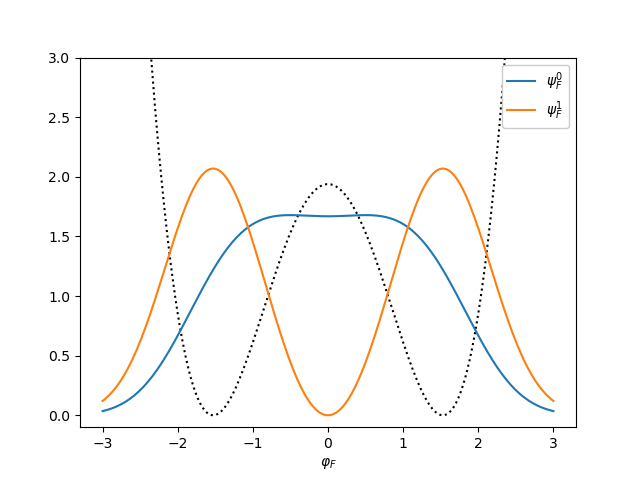

In [19]:
φ_f = np.linspace(-3,3,200)
φ_ext = np.pi
V_f = 0.5 * E_L_f * (φ_f)**2 - E_J * np.cos(φ_f-φ_ext)

n_eig = 2
fluxonium.set_trunc_nums([20])
loop_fluxonium.set_flux(φ_ext/2/np.pi)
_, _ = fluxonium.diag(n_eig)
states_f = [fluxonium.eig_phase_coord(k=i, grid=[φ_f/2/np.pi]) for i in range(n_eig)]
# states_f = [fluxonium.eig_phase_coord(k=i, grid=[φ_q]) for i in range(n_eig)]
labels_f = [r'$\psi_F^0$', r'$\psi_F^1$']

fig, ax_f = plt.subplots()
for ax in [ax_f, axs_eigs[0,1]]:
    ax.plot(φ_r, (V_f-V_f.min())/1e9, 'k:')#, label = r'$\frac{1}{2}E_{L_{F}}\varphi_F^2 - E_J\cos(\varphi_F-\varphi_{ext})$')
    [ax.plot(φ_f, np.abs(state)**2, label = label) for state, label in zip(states_f, labels_f)]
    ax.set_ylim([-.1,3])
    ax.set_xlabel(r'$\varphi_F$')
    ax.legend(loc=1, framealpha=1)

fig.show()

## Eigenstates of the qubit in phase base

In [20]:
qubit.set_trunc_nums([1,5,10])

# creat the phase grid
phi1 = 0
phi2 = np.linspace(-.03, .03, 100)
phi3 = np.linspace(-3, 3 , 100)
grid = [phi1, phi2/2/np.pi, phi3/2/np.pi]

state0_vs_ext_flux = []
state1_vs_ext_flux = []
state2_vs_ext_flux = []
state3_vs_ext_flux = []

ext_flux_list = [0.5, 0.55, 0.65, 1]
# loop thorugh several values of external flux
for ext_flux in ext_flux_list:
    loop.set_flux(ext_flux)
    _, _ = qubit.diag(n_eig=5)

    # Calculate eigenstates in phase coord
    state0_vs_ext_flux.append(qubit.eig_phase_coord(0, grid=grid))
    state1_vs_ext_flux.append(qubit.eig_phase_coord(1, grid=grid))
    state2_vs_ext_flux.append(qubit.eig_phase_coord(2, grid=grid))
    state3_vs_ext_flux.append(qubit.eig_phase_coord(3, grid=grid))

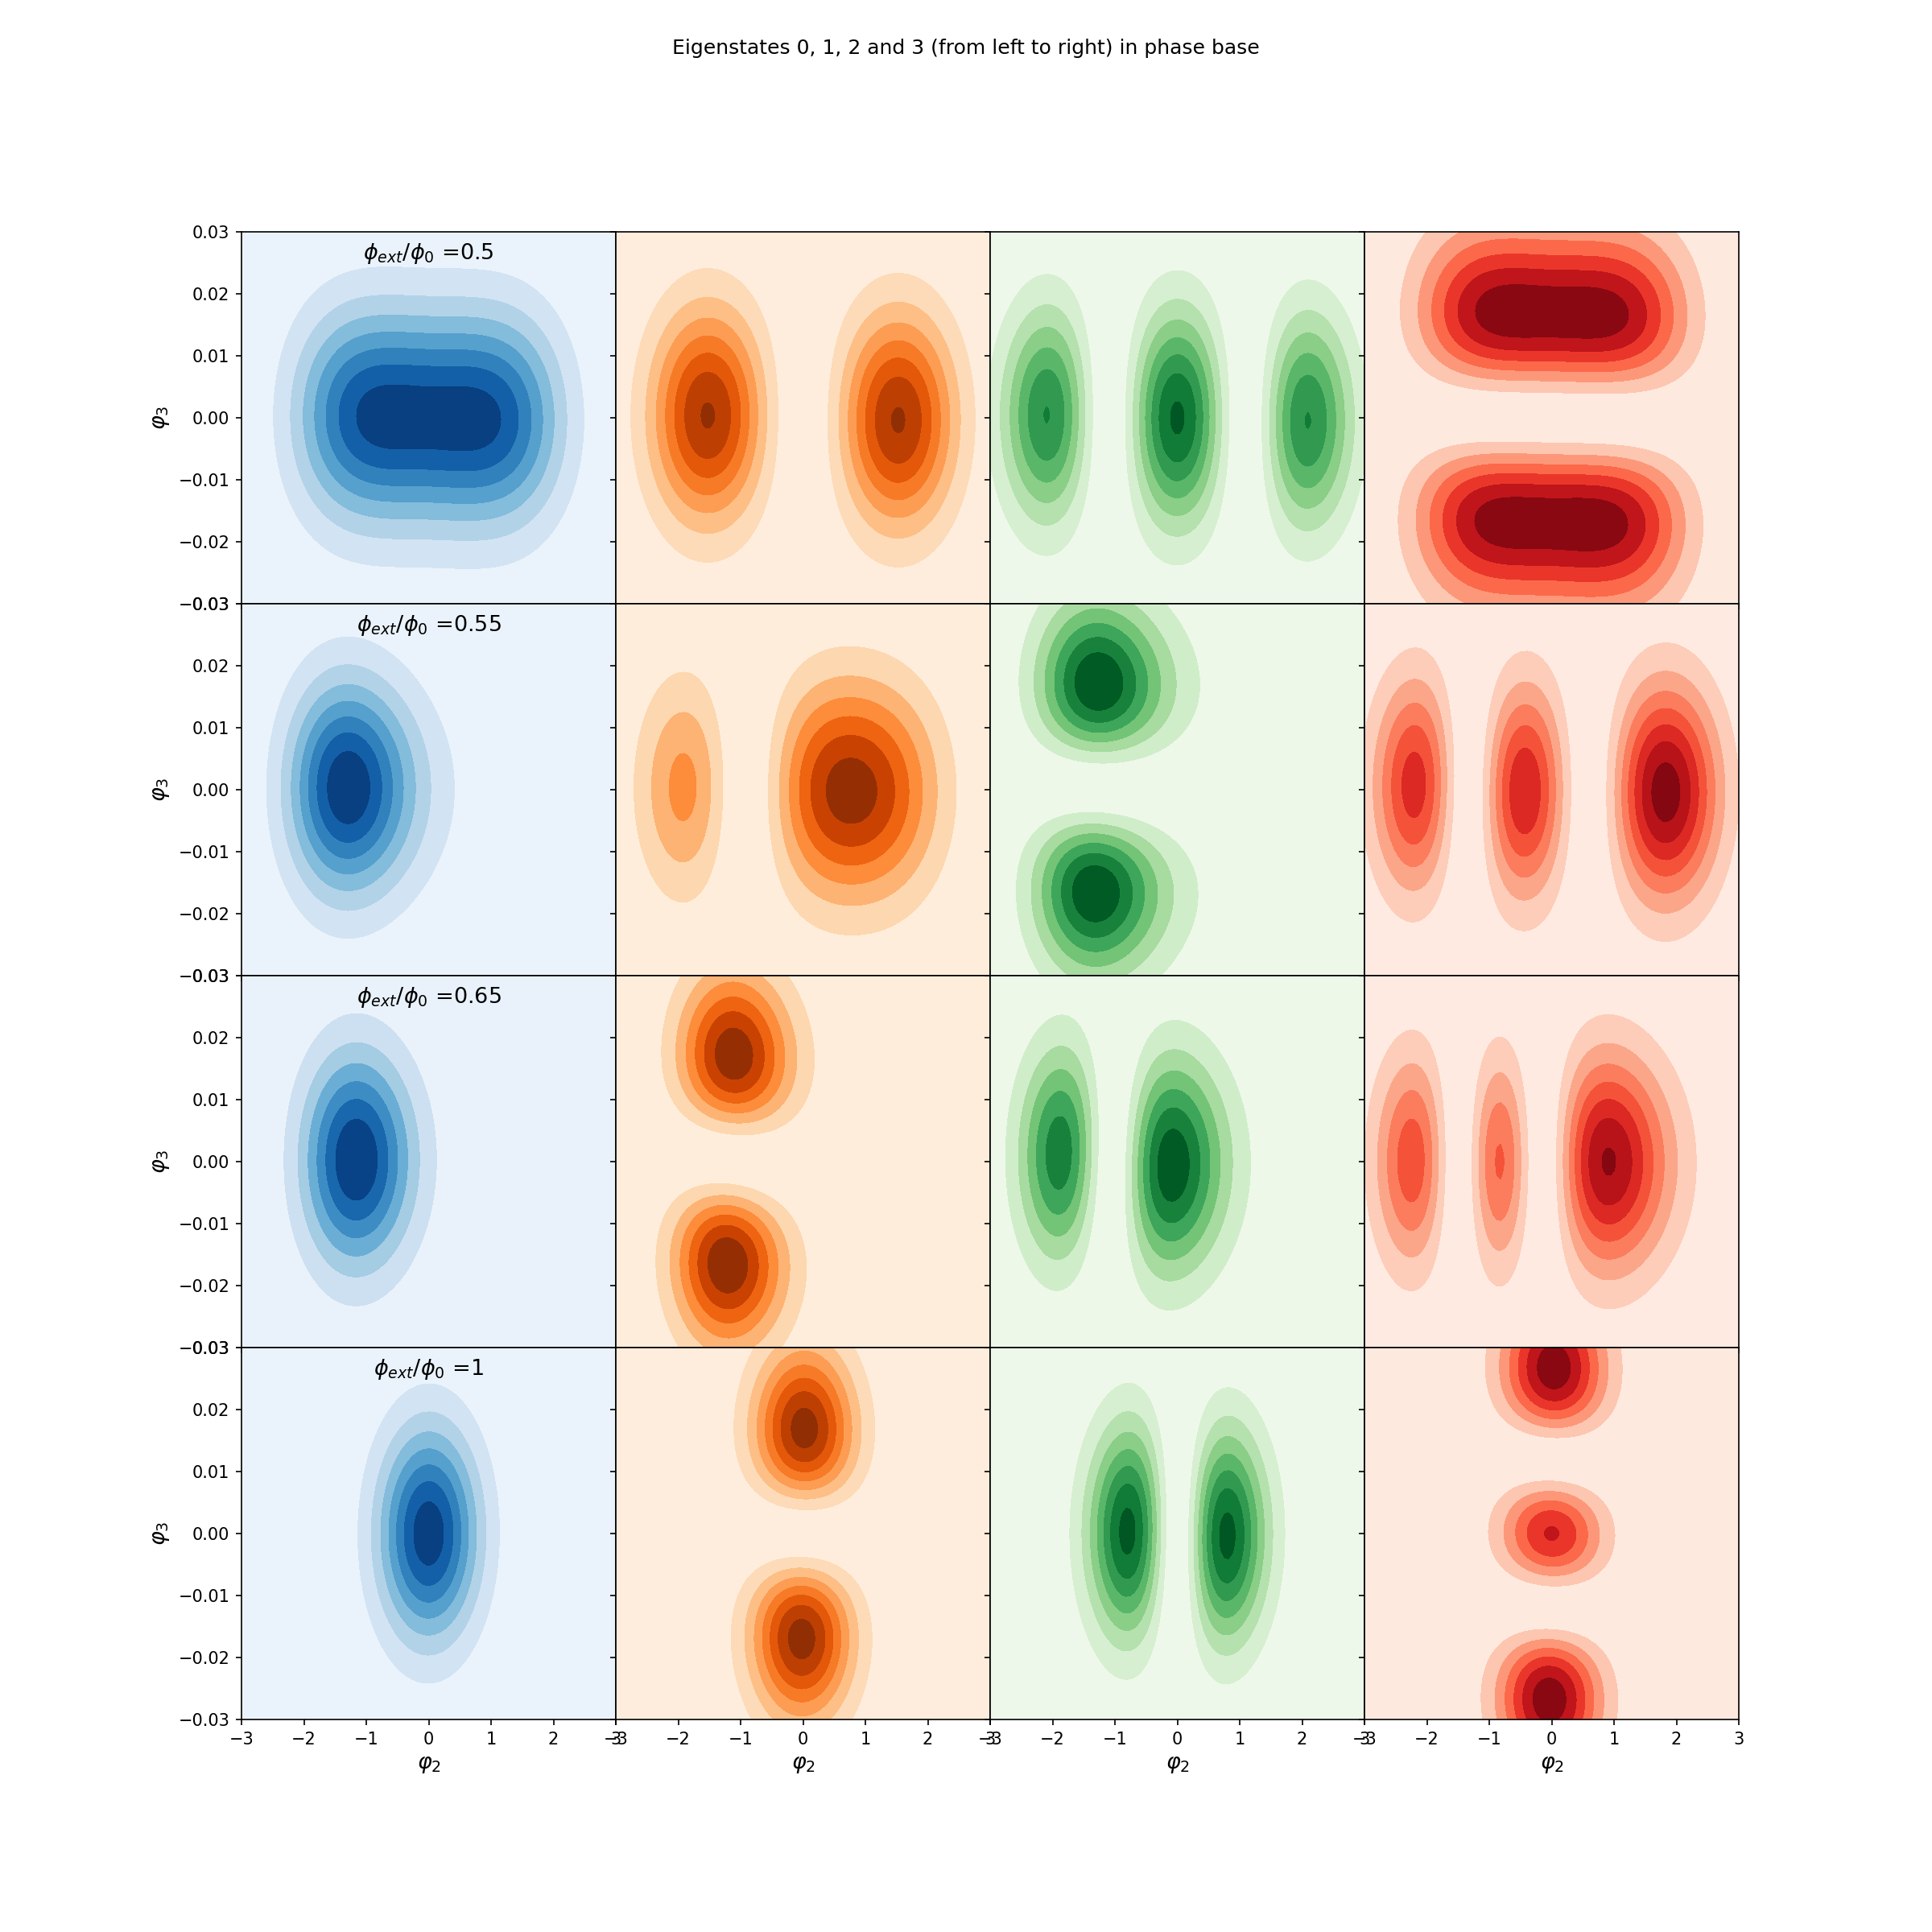

In [21]:
fig, axs = plt.subplots(4, 4, figsize=(4*4, 4*4), sharey='row', sharex = 'col', dpi=150)

for i, ext_flux in enumerate(ext_flux_list):
    axs[i, 0].contourf(phi3, phi2, np.abs(state0_vs_ext_flux[i].T) ** 2, cmap="Blues" )
    axs[i, 1].contourf(phi3, phi2, np.abs(state1_vs_ext_flux[i].T) ** 2, cmap="Oranges" )
    axs[i, 2].contourf(phi3, phi2, np.abs(state2_vs_ext_flux[i].T) ** 2, cmap="Greens")
    axs[i, 3].contourf(phi3, phi2, np.abs(state3_vs_ext_flux[i].T) ** 2, cmap="Reds"   )
    if i == 0:
        axs_eigs[1, 0].contourf(phi3, phi2, np.abs(state0_vs_ext_flux[i].T) ** 2, cmap="Blues")
        axs_eigs[1, 0]. set_ylabel(r'$\tilde{\varphi}_F$')
        axs_eigs[1, 0]. set_xlabel(r'$\tilde{\varphi}_R$')
        axs_eigs[1, 0].text(.9,.9, r'$\psi^0$', transform=axs_eigs[1, 0].transAxes, ha="center", va="center")
        axs_eigs[1, 1].contourf(phi3, phi2, np.abs(state1_vs_ext_flux[i].T) ** 2, cmap="Oranges")
        axs_eigs[1, 1]. set_ylabel(r'$\tilde{\varphi}_F$')
        axs_eigs[1, 1]. set_xlabel(r'$\tilde{\varphi}_R$')
        axs_eigs[1, 1].text(.9,.9, r'$\psi^1$', transform=axs_eigs[1, 1].transAxes, ha="center", va="center")
    for j in range(4):
        axs[-1, j].set_xlabel(r"$\varphi_2$", fontsize=13)
    axs[i, 0].set_ylabel(r"$\varphi_3$", fontsize=13)
    axs[i, 0].set_title('$\phi_{ext}/\phi_{0}$ ='+f'{ext_flux}', fontsize=13, y=0.9 )
fig.suptitle('Eigenstates 0, 1, 2 and 3 (from left to right) in phase base')
plt.subplots_adjust(wspace=0)
plt.subplots_adjust(hspace=0)
plt.show()

# Eigenstates of the separate and combined systems

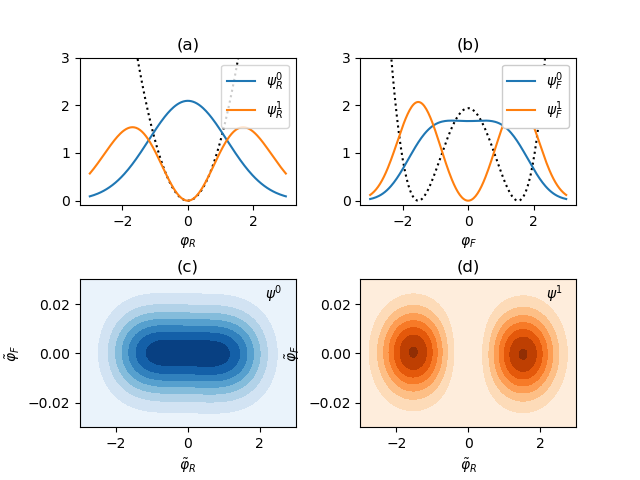

In [22]:
axs_eigs[0,0].set_title('(a)')
axs_eigs[0,1].set_title('(b)')
axs_eigs[1,0].set_title('(c)')
axs_eigs[1,1].set_title('(d)')
figs.export('Eigenstates.pdf', fig_eigs, hspace=.5, wspace=.3)
fig_eigs.show()

# Fluxonium-Resonator internal coupling in KIT's qubit

## Spectrum vs Δ

In [23]:
Δ_values = np.geomspace(1e-10,1e1, 50)
qubit_vs_Δ = [ sq_ext.KITqubit(Δ=Δ) for Δ in Δ_values]

trunc_nums = [1, 5, 10]
trunc_nums_Δ_0 = [ 5, 10]

for i, qubit_Δ in enumerate(qubit_vs_Δ):
    try:
        qubit_Δ.set_trunc_nums(trunc_nums)
    except:
        qubit_Δ.set_trunc_nums(trunc_nums_Δ_0)

In [24]:
# circuit = qubit_vs_Δ[-1]
circuit = qubit
n_eig=8
circuit.set_trunc_nums([1, 5, 10])
phi = np.linspace(0,0.5,100)

E_circuit = np.zeros((n_eig, len(phi)))

for i in range(len(phi)):
    circuit.loops[0].set_flux(phi[i])
    E_circuit[:, i] = circuit.diag(n_eig)[0]

In [25]:
φext_values = [0, 0.372, 0.5]

E_vs_Δ_φext = np.zeros([len(φext_values), len(Δ_values),  n_eig])

for i, φext in enumerate(φext_values):
    for j, qubit_Δ in enumerate(qubit_vs_Δ):
        qubit_Δ.loops[0].set_flux(φext)
        E_vs_Δ_φext[i, j , :] = qubit_Δ.diag(n_eig)[0]


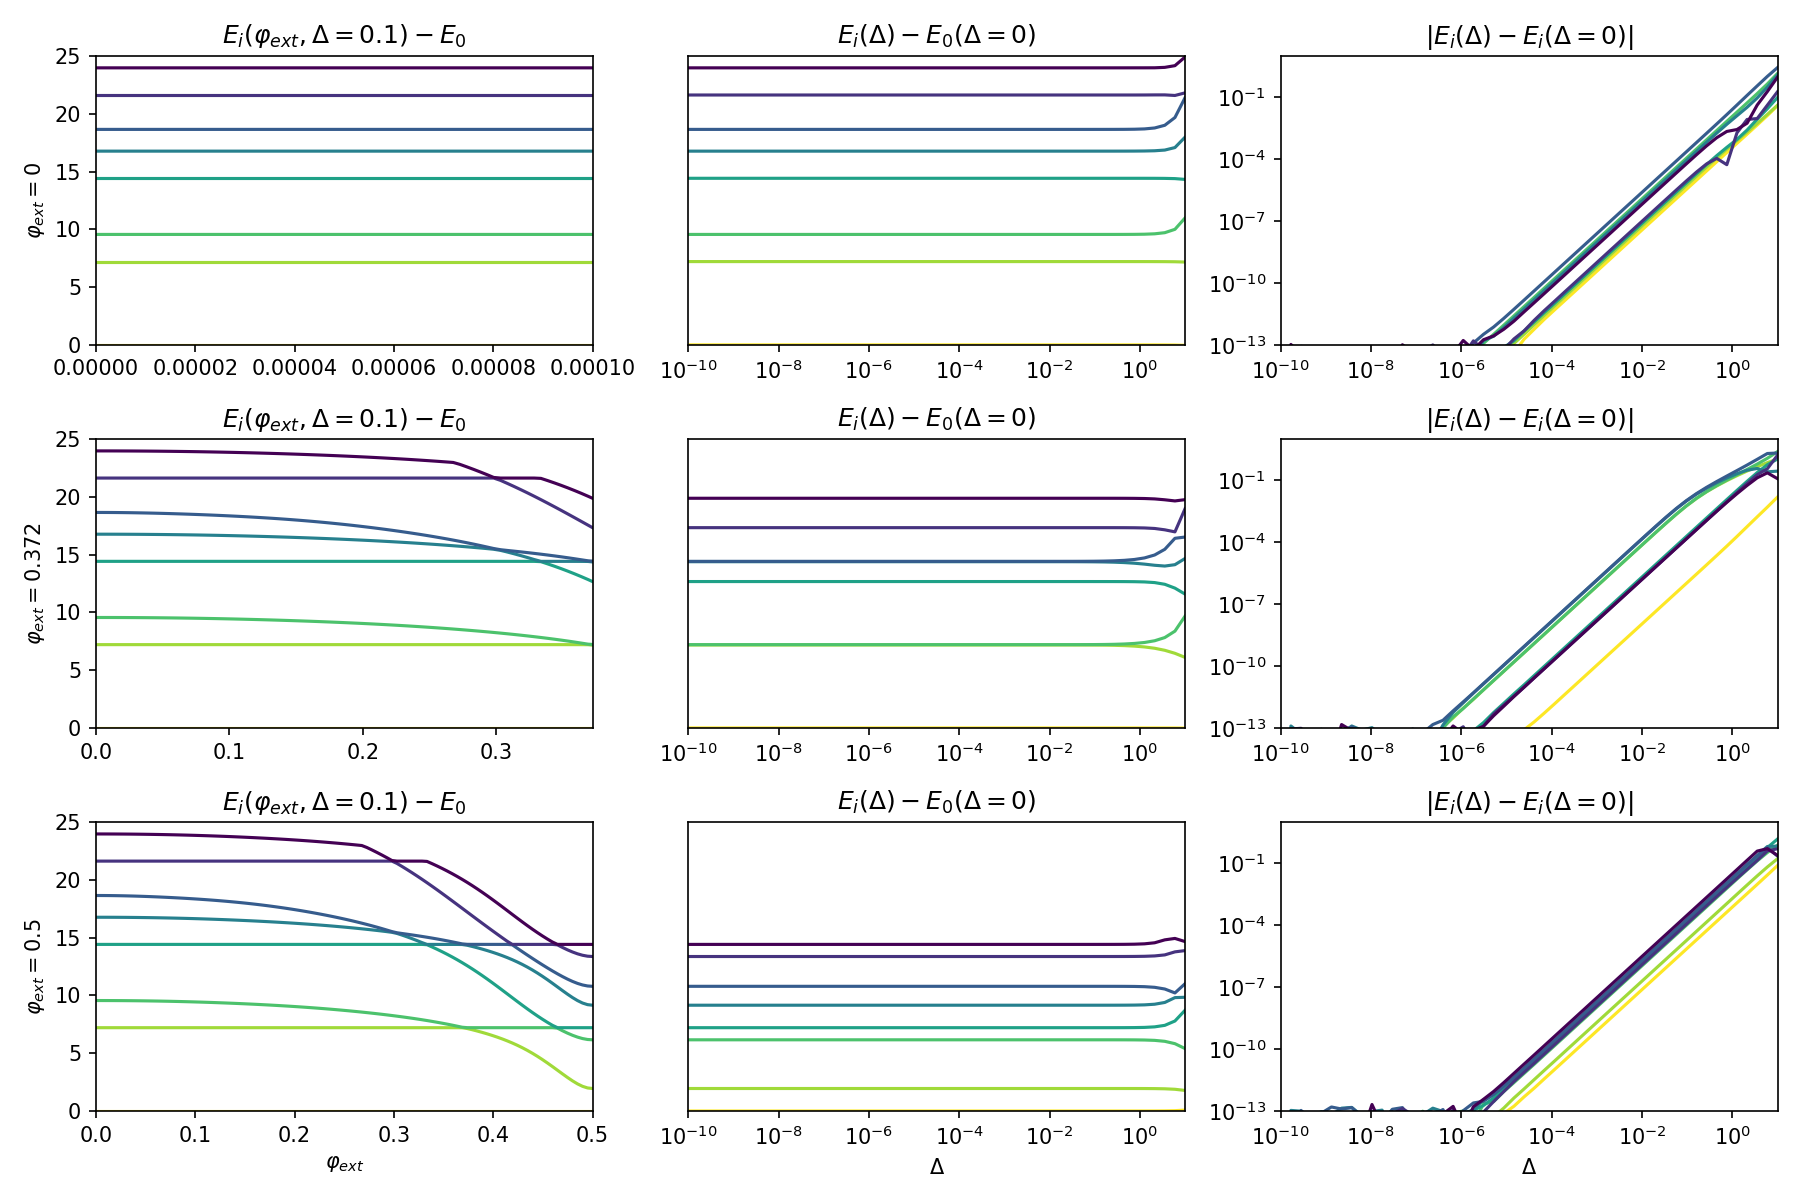

In [26]:
fig, axs = plt.subplots(nrows= 3, ncols = 3, figsize=[12,8], dpi=150)
eig_colors = plt.get_cmap('viridis_r')(np.linspace(0, 255, n_eig).astype('int'))

for i in range(n_eig):
    [axs[j,0].plot(phi, E_circuit[i,:]- E_circuit[0,:], color=eig_colors[i]) for j in range(len(φext_values)) ]

[axs[i,0].set_ylim([0,25]) for i in range(len(φext_values))]
[axs[i,0].set_title(r"$E_i(\varphi_{ext}, \Delta=0.1)-E_0$") for i in range(len(φext_values))]
[axs[i,0].set_ylabel(r'$ \varphi_{ext}=$' + f'{φext_values[i]}' ) for i in range(len(φext_values))]
axs[2,0].set_xlabel(r'$\varphi_{ext}$')

for i, φext in enumerate(φext_values):
    axs[i,0].set_xlim([0, φext+0.0001])
    for j in range(n_eig):
        axs[i,1].plot(Δ_values, E_vs_Δ_φext[i, :, j]- E_vs_Δ_φext[i, 0, 0], color=eig_colors[j])
        axs[i,2].plot(Δ_values, np.abs(E_vs_Δ_φext[i, :, j]- E_vs_Δ_φext[i, 0, j]), color=eig_colors[j])

    axs[i,1].margins(0)
    axs[i,1].set_ylim([0,25])
    axs[i,1].set_yticks([])
    axs[i,1].set_title(r'$E_i(\Delta)-E_0(\Delta=0)$')
    axs[i,1].set_xscale('log')
    axs[i,2].set_title(r'$|E_i(\Delta)-E_i(\Delta=0)|$')
    axs[i,2].set_xscale('log')
    axs[i,2].set_yscale('log')
    axs[i,2].margins(0)
    axs[i,2].set_ylim([1e-13, 1e1])

axs[2,1].set_xlabel(r'$\Delta$')
axs[2,2].set_xlabel(r'$\Delta$')

fig.tight_layout()
fig.show()

### Approach 1: Numerical evaluation of the coupling that has been deduced from the Hamiltonian.

### Approach 1a: Using the fluxonium and resonator circuits.

In [27]:
qubit.set_trunc_nums([1, 15, 15])
resonator.set_trunc_nums([15])
fluxonium.set_trunc_nums([15])

loop.set_flux(0.5)
loop_fluxonium.set_flux(0.5)

_ = qubit.diag(2)
_ = fluxonium.diag(2)
_ = resonator.diag(2)

In [28]:
Δ01 = qubit.efreqs[1]- qubit.efreqs[0]
Δ01

1.9453602983437728

In [42]:
H = qubit.hamiltonian_op(0, basis='eig')

In [41]:
sq_ext.decomposition_in_pauli_2x2(qubit.hamiltonian_op(0, basis='eig').__array__())[-1] / GHz /2 /np.pi * -1 * 2

1.945360298343801

In [29]:
sq_ext.decomposition_in_pauli_2x2(sq_ext.H_eff_SWT_circuit(qubit, qubit))[-1] / GHz /2 /np.pi * -1 * 2

/home/gabriel/PycharmProjects/tunable-capacitive-coupling-flux-qubits/Modules/SQcircuit_extensions.py:101: ComplexWarning: Casting complex values to real discards the imaginary part
  P[i] = 0.5 * np.trace(s[i].T.conjugate() @ A)


1.9453602983437719

In [30]:
L_c = l / Δ * 1e-9
E_L_c = (Φ_0/(2*np.pi))**2/L_c / h / GHz
E_L_c

0.010059417635312939

In [31]:
Φ_f = sq_ext.decomposition_in_pauli_2x2(fluxonium.flux_op(0, basis='eig').__array__())[1]
Φ_f

38.41921243891208

In [32]:
# This should be the same as that calculated analytically
Φ_r = sq_ext.decomposition_in_pauli_2x2(resonator.flux_op(0, basis='eig').__array__())[1]
Φ_r

38.365883888556986

In [33]:
g = Φ_r * Φ_f / L_c / GHz  #/ 2 /np.pi
print(g)

0.09070912782598373


In [34]:
g / Δ01 * 100

4.662844610492516

### Approach 1b: Using the full circuit

In [99]:
sq_ext.print_flux_transformation(qubit_equiv)

Φ_1 = [-1.00  0.00]
Φ_2 = [ 0.02  1.00]


In [100]:
qubit.set_trunc_nums([1, 15,15])
_ = qubit.diag(2)
qubit_equiv.set_trunc_nums([15,15])
_ = qubit_equiv.diag(2)

In [101]:
sq_ext.decomposition_in_pauli_2x2(qubit.flux_op(1, basis='eig').__array__())

array([-1.1e-17, -9.7e-03, 9.4e-16, -2.2e-16])

In [102]:
sq_ext.decomposition_in_pauli_2x2(qubit.flux_op(2, basis='eig').__array__())

array([1.3e-14, 3.8e+01, 1.4e-14, 7.1e-14])

### Approach 2: Analytical approximation of the coupling that has been deduced from the Hamiltonian.

In [103]:
dVdφ =  lambda φ: E_L_f*φ + E_J*np.sin(φ+np.pi)
φ_min = sp.optimize.fsolve(dVdφ, 1)[0]
φ_min

1.5279722082410827

In [104]:
Φ_f_an =(Φ_0 / (2*np.pi)) * φ_min / np.sqrt(sq.hbar)
Φ_f_an

48.968088326233854

In [105]:
# This should be the same as that calculated numerically
Φ_r_an = np.sqrt(1/2 * np.sqrt(L_r/C_r))
Φ_r_an

38.36589667717856

In [106]:
g_an = Φ_f_an * Φ_r_an /L_c  /GHz
g_an

0.11561543774635939

In [107]:
g_an / Δ01 * 100

5.943137517753973

### Approach 3: Extract the coupling by applying the SWT to project the qubit onto the qubit without interaction (Delta=0)

In [57]:
_ = qubit.diag(2)
_ = qubit_vs_Δ[0].diag(2)
# H_eff = sq_ext.H_eff_SWT_circuit(qubit_vs_Δ[0], qubit_vs_Δ[0]) / GHz / 2 / np.pi
H_eff = sq_ext.H_eff_SWT_circuit(qubit, qubit) / GHz / 2 / np.pi
P = sq_ext.decomposition_in_pauli_2x2(H_eff)
E0 = P[0]
Δ_01 = P[-1] * 2
E0, Δ_01/2

(7.679639955890468, -0.9726801491718531)

In [59]:
print(np.round(H_eff, 6))

[[6.70696-0.j 0.     -0.j]
 [0.     +0.j 8.65232+0.j]]


In [62]:
print(np.round(H_eff - E0*np.eye(len(H_eff)), 6))

[[-0.97268-0.j  0.     -0.j]
 [ 0.     +0.j  0.97268+0.j]]


In [64]:
qubit.diag(4)
H_eff = sq_ext.H_eff_SWT_circuit(qubit, qubit) / GHz / 2 / np.pi
print(np.round(H_eff, 6))

[[ 6.70696 +0.j  0.      -0.j -0.      -0.j -0.      +0.j]
 [ 0.      +0.j  8.65232 +0.j  0.      -0.j -0.      +0.j]
 [-0.      +0.j  0.      +0.j 12.868043-0.j  0.      +0.j]
 [-0.      -0.j -0.      -0.j  0.      -0.j 13.91541 +0.j]]


In [71]:
Δ_values[40]

0.09540954763499924

In [86]:
circ_0 = qubit_vs_Δ[0]
circ = qubit_vs_Δ[41]
circ = qubit

n_eig = 4
try:
    circ_0.set_trunc_nums([15,15])
except:
    circ_0.set_trunc_nums([1, 15,15])
circ.set_trunc_nums([1,15,15])

_ = circ_0.diag(n_eig)
_ = circ.diag(n_eig)

H_eff = sq_ext.H_eff_SWT_circuit(circ_0, circ) / GHz / 2 / np.pi

print(np.round(H_eff, 6))

[[ 6.7069600e+00+0.j -0.0000000e+00+0.j  1.3100000e-04+0.j  0.0000000e+00+0.j]
 [-0.0000000e+00-0.j  8.6536880e+00+0.j -0.0000000e+00-0.j  8.4840000e-02+0.j]
 [ 1.3100000e-04-0.j -0.0000000e+00+0.j  1.2868043e+01+0.j -0.0000000e+00-0.j]
 [ 0.0000000e+00-0.j  8.4840000e-02-0.j -0.0000000e+00+0.j  1.3914042e+01+0.j]]


In [75]:
np.abs(H_eff[1,3])

0.05077474162171398

 (10.536+0j)	*	 I ⨂I 
 (-0.748-0j)	*	 I ⨂σz 
 (0.042-0j)	*	 σx ⨂I 
 (-0.042+0j)	*	 σx ⨂σz 
 (-2.855+0j)	*	 σz ⨂I 
 (-0.225+0j)	*	 σz ⨂σz 


array([[10.536+0.j, -0.   +0.j,  0.   +0.j, -0.748-0.j],
       [ 0.042-0.j,  0.   +0.j, -0.   +0.j, -0.042+0.j],
       [-0.   -0.j, -0.   +0.j, -0.   +0.j,  0.   +0.j],
       [-2.855+0.j,  0.   +0.j, -0.   +0.j, -0.225+0.j]])